In [1]:
import numpy as np
import pandas as pd
from typing import List
from dataclasses import dataclass
import pickle
import statistics
import math
from IPython.display import Image

In [2]:
@dataclass
class Sign:
  userID: int
  genuine: bool
  data: pd.DataFrame
  feature_vector: np.ndarray
  
@dataclass
class User:
  userID: int
  signatures: list[Sign]

In [3]:
# Deserialization of users
with open('devUsers.pkl', 'rb') as in_file:
    devUsers = pickle.load(in_file)

with open('evalUsers.pkl', 'rb') as in_file:
    evalUsers = pickle.load(in_file)

In [4]:
# All development data 
X_dev = np.ndarray((25728+42320, 26))
Y_dev = np.ndarray((25728+42320, 1))
k = 0
for user in devUsers:
    for i in range(4):
        # The first 4 signatures are the base genuine signatures
        # and we compare them to the other 46 signatures of the user, 
        # from which 21 are genuine and 25 are forged
        for j in range(4,len(user.signatures)):
            # We subtract the feature vectors of the signatures
            # and the neural network will learn to decide whether this difference is genuine or forged
            X = np.absolute(np.subtract(user.signatures[i].feature_vector, user.signatures[j].feature_vector))
            X_dev[k] = X
            # 0 if the comparison is genuine, 1 if forged
            Y = 0 if user.signatures[j].genuine else 1
            # one hot encoding?
            # Y = np.array([Y, 1-Y])
            Y_dev[k] = Y
            k += 1

In [5]:
# MCYT-100 -> 4*46*100 = 18400 vectors for validation and testing
X_eval = np.ndarray(shape=(18400, 26))
Y_eval = np.ndarray(shape=(18400, 1))
k = 0
for user in evalUsers:
    if user.userID > 100:
        break
    for i in range(4):
        for j in range(4,50):
            X = np.absolute(np.subtract(user.signatures[i].feature_vector, user.signatures[j].feature_vector))
            # 0 if the comparison is genuine, 1 if forged
            Y = 0 if user.signatures[j].genuine else 1
            X_eval[k] = X
            Y_eval[k] = Y
            k += 1


In [6]:
# Shuffle the data so that the neural network won't learn the order of the signatures
# p = np.random.permutation(len(X_dev))
# X_dev = X_dev[p]
# Y_dev = Y_dev[p]

from sklearn.utils import shuffle
X_dev, Y_dev = shuffle(X_dev, Y_dev, random_state=0)
X_eval, Y_eval = shuffle(X_eval, Y_eval, random_state=0)

In [7]:
X_train = X_dev
Y_train = Y_dev
X_valid = X_eval[:12000]
Y_valid = Y_eval[:12000]
X_test = X_eval[12000:]
Y_test = Y_eval[12000:]

print(X_train.shape, X_valid.shape, X_test.shape)

(68048, 26) (12000, 26) (6400, 26)


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model

from keras import regularizers
from keras.models import load_model
from keras_visualizer import visualizer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns;

# Random seed beállítása
np.random.seed(1)
tf.random.set_seed(1)

In [9]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [19]:
len(devUsers[0].signatures[0].feature_vector)

26

In [47]:
# Modell felépítése és tanítása
model = Sequential()
feature_vector_size = len(devUsers[0].signatures[0].feature_vector)
# kernel_regularizer=regularizers.l2(0.1)
model.add(Dense(200, input_shape=(feature_vector_size,), activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(20, activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=0.01)

model.compile(loss ='binary_crossentropy', optimizer = optimizer, metrics =['accuracy'])

patience = 50
early_stopping = EarlyStopping(patience=patience, verbose=1)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

fit_history = model.fit(X_train, Y_train,
            batch_size=400,
            epochs=5000,
            verbose=2,
            validation_data=(X_valid,Y_valid),
            callbacks=[ reduce_lr,
                        checkpointer,
                        early_stopping
                        ],
            shuffle= True)

Epoch 1/5000

Epoch 1: val_loss improved from inf to 0.32232, saving model to weights.hdf5
171/171 - 2s - loss: 0.5122 - accuracy: 0.7470 - val_loss: 0.3223 - val_accuracy: 0.8770 - lr: 0.0100 - 2s/epoch - 10ms/step
Epoch 2/5000


c:\Users\David\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 0.32232 to 0.28803, saving model to weights.hdf5
171/171 - 1s - loss: 0.3187 - accuracy: 0.8747 - val_loss: 0.2880 - val_accuracy: 0.8934 - lr: 0.0100 - 775ms/epoch - 5ms/step
Epoch 3/5000

Epoch 3: val_loss did not improve from 0.28803
171/171 - 1s - loss: 0.3034 - accuracy: 0.8825 - val_loss: 0.3086 - val_accuracy: 0.8773 - lr: 0.0100 - 771ms/epoch - 5ms/step
Epoch 4/5000

Epoch 4: val_loss improved from 0.28803 to 0.28354, saving model to weights.hdf5
171/171 - 1s - loss: 0.2940 - accuracy: 0.8863 - val_loss: 0.2835 - val_accuracy: 0.8723 - lr: 0.0100 - 772ms/epoch - 5ms/step
Epoch 5/5000

Epoch 5: val_loss did not improve from 0.28354
171/171 - 1s - loss: 0.2857 - accuracy: 0.8877 - val_loss: 0.3016 - val_accuracy: 0.8852 - lr: 0.0100 - 755ms/epoch - 4ms/step
Epoch 6/5000

Epoch 6: val_loss did not improve from 0.28354
171/171 - 1s - loss: 0.2841 - accuracy: 0.8898 - val_loss: 0.2841 - val_accuracy: 0.8899 - lr: 0.0100 - 782ms/epoch - 5ms/step
Epoch

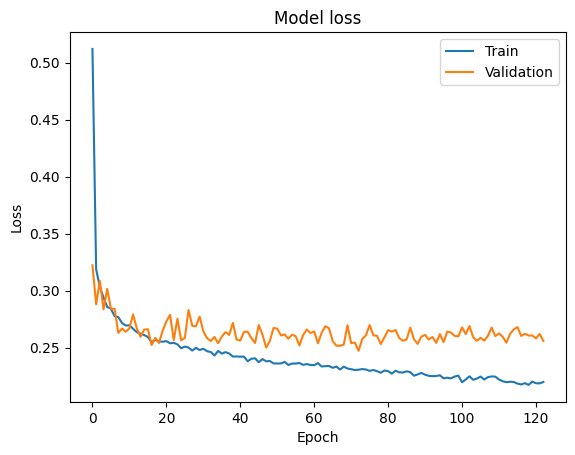

In [48]:
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [49]:
model = load_model('weights.hdf5')

In [ ]:
# visualizer(model, file_format='png', view=True)
# Image(filename='graph.png', width=800)

In [ ]:
model.summary()

In [50]:
preds = model.predict(X_test)

# Compute FAR and FRR
fpr, tpr, thresholds = roc_curve(Y_test, preds)
far = fpr
frr = 1 - tpr

# Find the optimal threshold (EER)
eer = thresholds[np.nanargmin(np.absolute((far - frr)))]

print('Best Threshold=%f' % eer)

200/200 [==============================] - 0s 778us/step
Best Threshold=0.434182


Number of correct predictions: 5771
Number of wrong predictions: 629
Accuracy: 0.90171875


[Text(0.5, 14.722222222222216, 'Predicted Label'),
 Text(33.22222222222222, 0.5, 'True label')]

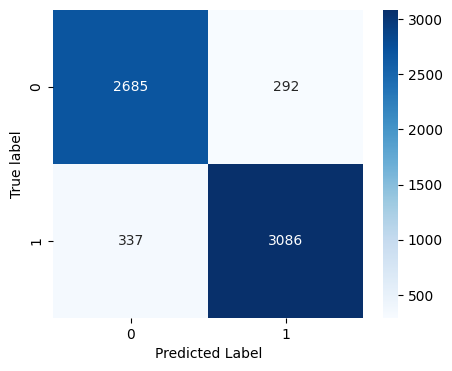

In [51]:
preds_binary = np.where(preds > eer, 1, 0)
conf = confusion_matrix(Y_test, preds_binary)
# Compare the predictions with the actual values
correct_preds = np.sum(preds_binary == Y_test)
wrong_preds = len(Y_test) - correct_preds

print(f"Number of correct predictions: {correct_preds}")
print(f"Number of wrong predictions: {wrong_preds}")
print(f"Accuracy: {accuracy_score(Y_test, preds_binary)}")

plt.figure(figsize=(5,4))
ax = sns.heatmap(conf, annot=True, fmt='d', cmap=plt.cm.Blues)
ax.set(xlabel='Predicted Label',
       ylabel='True label')